# Multi-arm Bandit problem

### Introduction

Прежде всего подключим необходимые библиотеки для реализации алгоритмов. Здесь нам понадобится только работа с массивами и графиками для сравнения алгоритмов. Установим seed для воспроизводимости.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
np.random.seed(42)

Для начала определим объект Multi-arm bandit, который принимает на вход количество возможных действий и генерирует средние значения наград $\mu_a$ за каждое действие, $\mu_a \sim \mathcal{N}(0, 1)$. Также определим функцию play, которая имитирует совершение агентом действия $a$: среда возвращает выигрыш $r$, $r \sim \mathcal{N}(\mu_a, 1).$

In [2]:
class Multi_armed_bandit(object):
    def __init__(self, A):
        self.mu= np.random.normal(loc=0, scale=1, size=A)
    
    def play(self, i):
        return np.random.normal(loc=self.mu[i], scale=1)        
    
    def means(self):
        return self.mu

В качестве модельной задачи рассматриваем среду с 20 действиями. Каждый агент совершает 1000 действий. Сравнивать будем средние выигрыши каждого агента во все моменты игры, усредненные по 1000 итерациям (с разными средами).

In [3]:
A = 20
T = 1000
iterations = 1000

Каждый агент будет использовать следующие данные, которые изначально проинициализируем нулевыми значениями:
1.  Estimation ($Q_a$) - оценка агентом того или иного действия (смысл меняется в зависимости от алгоритма действий агента).
2.  Average reward ($R$) - средний выигрыш со всех действий на текущий момент времени. Он же является ожидаемым выигрышом в данный момент времени.
3.  Action count ($c_a$)- количество раз, когда совершалось каждой действие, на текущий момент
4.  History - история средних выигрышей с начала игры до текущего момента

Заметим, что $R$ можно вычислять следующим образом:
$$R_{t+1} = \frac{1}{t+1}(tR_t + r) = R_t + \frac{1}{t+1}(r - R_t).$$
Здесь $r$ - полученный в данный момент выигрыш. Заметим также, что эту формулу можно вычислять аналогично для средних выигрышей отдельный действий, если использовать action count. В первых стратегиях положим в качестве estimation средний выигрыш с соответствующего действия.

In [4]:
def Init_agent():
    estimation = np.zeros((A, 1))
    average_reward = 0
    action_count = np.zeros((A, 1))
    history = np.zeros((T + 1))
    return estimation, average_reward, action_count, history

### Greedy and $\varepsilon$-greedy policy

Начнем с $\varepsilon$-greedy стратегии.
1.  Если $\varepsilon = 0$, то стратегия превращается в greedy policy. Рассмотрим ее чуть подробнее. Суть ее заключается в выборе действия с наилучшим значением estimation, т.е. средним выигрышем в данном случае. Проблема заключается в том, что у такой стратегии низкий уровень исследования, т.к. почти сразу алгоритм начинает эксплуатировать действия, которые он уже совершал и которые дали наибольший выигрыш. При этом велика вероятность, что некоторые действия с лучшим выигрышем алгоритм и вовсе не совершит за всю игру. Одно из возможных решений - optimistic initial values - заключается в инициализации estimation не нулями, а какими-то большими числами, чтобы алгоритм хотя бы раз попробовал каждое действие. Однако ясно, что это не спасает. Во-первых, это слишком привязано к моменту времени, во-вторых, выигрышные действия при первом их выборе могут с некоторой вероятностью дать маленький выигрыш - в этом случае алгоритм их также не будет исследовать далее.
2. Если $\varepsilon \in (0, 1]$, то с вероятностью $\varepsilon$ алгоритм будет равновероятно выбирать действие с неоптимальным значением estimation, т.е. исследовать среду. Заметим, что чем меньше $\varepsilon$, тем более жадной становится стратегия, а чем больше $\varepsilon$, тем ближе алгоритм к случайной стратегии. Здесь мы считаем $\varepsilon$ константой на все время игры.

In [5]:
def Play_eps_greedy(mab, eps=0):
    Q_a, R, c_a, history = Init_agent()
    
    for t in range(T):
        p = np.random.rand()
        q_t_max = np.max(Q_a)
        max_values = np.where(Q_a == q_t_max)[0]
        
        if p > eps or max_values.shape[0] == A:
            i = np.random.choice(max_values, size=1)
        else:
            rest_values = np.where(Q_a < q_t_max)[0]
            i = np.random.choice(rest_values, size=1)
        
        r = mab.play(i)
        R += r
        if c_a[i] > 0:
            Q_a[i] += (r - Q_a[i]) / c_a[i]
        else:
            Q_a[i] = r
        c_a[i] += 1
        
        history[t + 1] = R
    
    return history

Реализуем две вспомогательные функции. Одна запускает выбранный алгоритм на нужное количество итераций с различными значениями параметра, после чего усредняет полученные истории для каждого значения.

In [15]:
def Try_values(dif_val, Play_strategy):
    history = np.zeros((dif_val.shape[0], T + 1))
    time_start = time.time()
    for i in range(1, iterations + 1):
        mab = Multi_armed_bandit(A)
        for j in range(dif_eps.shape[0]):
            history[j, :] += Play_strategy(mab, dif_val[j])
        s1 = '\rIteration: ' + str(i) + '/' + str(iterations) + '\t'
        if i % 100 == 0:
            s2 = 'Time: ' + str(time.time() - time_start)
            print(s1, s2, end='\n')
        else:
            print(s1, end='')
    
    history /= iterations
    return history

Вторая функция строит график в осях [номер действия ($t$)] $\times$ [усредненный суммарный выигрыш ($R_t$)].

In [16]:
colors = ['green', 'red', 'black', 'blue', 'yellow', 'orange', 'purple']

def Plot_figure(history, name, dif_val):
    fig = plt.figure(figsize=(20, 10))

    for i in range(history.shape[0]):
        plt.plot(range(T + 1), history[i], c=colors[i], label=name + ' = ' + str(dif_val[i]))
    
    leg = plt.legend()
    plt.show()

Запустим $\varepsilon$-greedy стратегию с параметром $\varepsilon \in \{0, 0.05, 0.1, 0.15, 0.2\}$ и сравним результаты на графике.

In [ ]:
dif_eps = np.array([0, 0.05, 0.1, 0.15, 0.2])
history_eps = Try_values(dif_eps, Play_eps_greedy)
Plot_figure(history_eps, 'eps', dif_eps)

Iteration: 100/1000	 Time: 57.18343496322632
Iteration: 200/1000	 Time: 113.58838129043579
Iteration: 300/1000	 Time: 40986.23018503189
Iteration: 400/1000	 Time: 108480.39673376083
Iteration: 500/1000	 Time: 108559.51109075546
Iteration: 600/1000	 Time: 108617.11057853699
Iteration: 700/1000	 Time: 108673.4377272129
Iteration: 717/1000	

Видно, что $\varepsilon$-greedy стратегия оказалась ожидаемо лучше, чем просто greedy policy. Оптимальный выигрыш наблюдается при $\varepsilon \approx 0.1$

### Softmax greedy policy

Теперь попробуем немного изменить стратегию. Значения estimation будем вычислять так же, но вероятность выбора действия a положим равной
$$\frac{\exp(\frac{1}{\varepsilon}Q_a)}{\sum_b \exp(\frac{1}{\varepsilon}Q_b)}, \text{где } \varepsilon > 0$$
Тогда при $\varepsilon \to \infty$ получим случайную стратегию, а при $\varepsilon \to 0$ получим greedy policy.

In [9]:
def Play_softmax(mab, temp=0.3):
    Q_a, R, c_a, history = Init_agent()
    
    for t in range(T):
        p = np.e ** (Q_a / temp)
        p /= np.sum(p)
        
        i = np.random.choice(range(A), size=1, p=p[:, 0])
        r = mab.play(i)
            
        R += r
        if c_a[i] > 0:
            Q_a[i] += (r - Q_a[i]) / c_a[i]
        else:
            Q_a[i] = r
        c_a[i] += 1
        
        history[t + 1] = R
    
    return history

Посмотрим на результаты данной softmax стратегии в рамках модельной задачи. Будем подставлять различные значения температуры ($\varepsilon$, функция softmax использует уравнение Больцмана-Гиббса, в котором фигурирует температура). А именно $\varepsilon \in \{0.1, 0.2, 0.3, 0.4, 0.5\}$.

Iteration: 100/1000	 Time: 28.329869031906128
Iteration: 200/1000	 Time: 56.67862868309021
Iteration: 300/1000	 Time: 85.03828978538513
Iteration: 400/1000	 Time: 113.37650918960571
Iteration: 500/1000	 Time: 141.68688869476318
Iteration: 600/1000	 Time: 170.15684533119202
Iteration: 700/1000	 Time: 198.45349550247192
Iteration: 800/1000	 Time: 226.6939766407013
Iteration: 900/1000	 Time: 255.11399817466736
Iteration: 1000/1000	 Time: 283.32614493370056


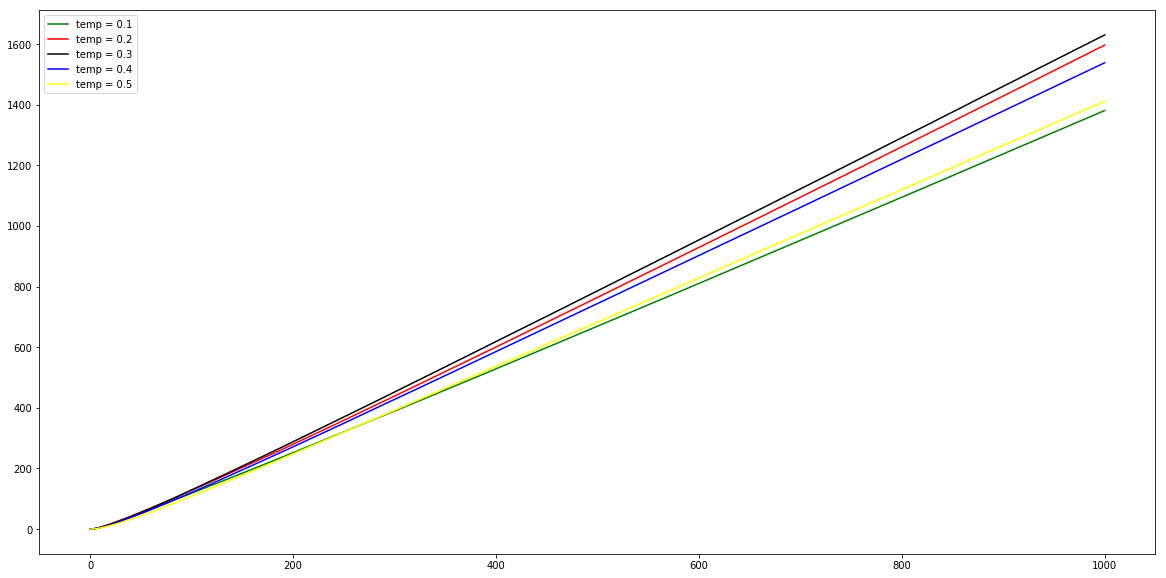

In [10]:
dif_temp = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
history_sm = Try_values(dif_temp, Play_softmax)
Plot_figure(history_sm, 'temp', dif_temp)

Видно, что лучшая версия данной стратегии ведет себя лучше, чем оптимальная из $\varepsilon$-greedy стратегий.

### Upper confidence bound policy

Попробуем теперь еще одну стратегию. Если есть еще неопробованные действия, выберем любое из них равновероятно. Иначе поступим следующим образом. Пусть предпочтение действия a равно
$$Q_a + c\sqrt{\frac{2\ln{t}}{c_a}}.$$
Т.е. если какое-то действие не совершается долго, вероятность его выбора растет. Обратно, если действие выбирается слишком часто, вероятность его падает. Таким образом агент регулирует исследование и эксплуатацию действий. Заметим, что при $c = 0$ мы получим жадную стратегию, а рост $c$ дает больший уклон в сторону исследования среды.

In [11]:
def Play_ucb(mab, c=1):
    Q_a, R, c_a, history = Init_agent()
    
    for t in range(T):
        
        not_used = np.where(c_a == 0)[0]
        if not_used.shape[0]:
            i = np.random.choice(not_used, size=1)
        else:
            effectiveness = Q_a + c * np.sqrt(np.log(t) / c_a)
            best_eff = np.max(effectiveness)
            Argmax = np.where(effectiveness == best_eff)[0]
            i = np.random.choice(Argmax, size=1)
            
        r = mab.play(i)
        R += r
        if c_a[i] > 0:
            Q_a[i] += (r - Q_a[i]) / c_a[i]
        else:
            Q_a[i] = r
        c_a[i] += 1
        
        history[t + 1] = R
    
    return history

Запустим и этот алгоритм на модельной задаче, положив $c \in \{0.5, 1, 1.5, 2, 2.5\}$.

Iteration: 100/1000	 Time: 20.388751983642578
Iteration: 200/1000	 Time: 40.85083031654358
Iteration: 300/1000	 Time: 61.19680213928223
Iteration: 400/1000	 Time: 81.59446740150452
Iteration: 500/1000	 Time: 101.93152809143066
Iteration: 600/1000	 Time: 122.30945658683777
Iteration: 700/1000	 Time: 142.69009518623352
Iteration: 800/1000	 Time: 163.05982160568237
Iteration: 900/1000	 Time: 183.38386750221252
Iteration: 1000/1000	 Time: 203.77550625801086


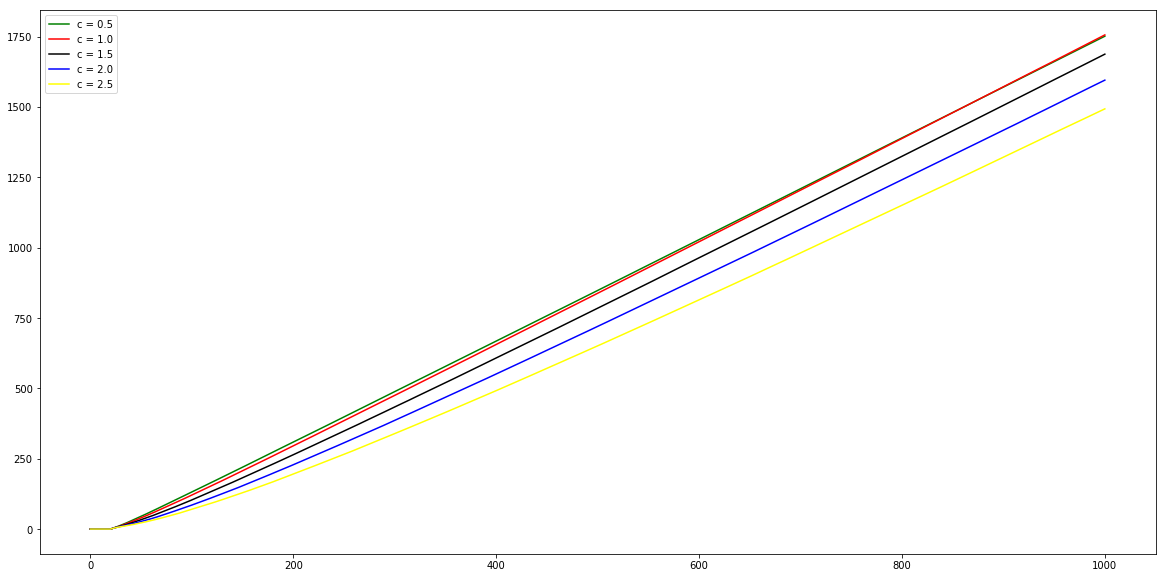

In [12]:
dif_c = np.array([0.5, 1, 1.5, 2, 2.5])
history_ucb = Try_values(dif_c, Play_ucb)
Plot_figure(history_ucb, 'c', dif_c)

Видно, что алгоритм показывает лучшие результаты среди уже рассмотренных.

### Gradient bandit policy

Попробуем еще один метод. А именно, аналог градиентного "подъема". Здесь estimation вычисляется по формуле
$$H_a = H_a + \alpha(r - R)(1 - \pi_a), \ a = a_t, \\ H_a = H_a - \alpha(r - R)\pi_a, \ a \neq a_t,$$
где $a_t$, выбранное действие, $\pi_a$ - вероятность выбора действия, согласно стратегии. Вероятности в свою очеред выбираются с помощью функции softmax:
$$\pi_a = \frac{\exp(H_a)}{\exp(\sum_b H_b)}.$$

In [13]:
def Play_gradient(mab, alpha=0.1):
    H_a, R, c_a, history = Init_agent()
    R_total = 0
    
    for t in range(T):
        p = np.e ** H_a
        p /= np.sum(p, axis=0)
        
        i = np.random.choice(range(A), size=1, p=p[:, 0])
        r = mab.play(i)
        
        R_total += r
        R += (r - R) / (t + 1)
        H_chosen = H_a[i] + alpha * (r - R) * (1 - p[i])
        H_a = H_a - alpha * (r - R) * p
        H_a[i] = H_chosen
        
        history[t + 1] = R_total
    
    return history

Запустим алгоритм с параметром $\alpha \in \{\frac18, \frac14, \frac12, 1, 2 \}$.

Iteration: 100/1000	 Time: 29.977800846099854
Iteration: 200/1000	 Time: 60.13366103172302
Iteration: 300/1000	 Time: 90.52717638015747
Iteration: 400/1000	 Time: 120.7354326248169
Iteration: 500/1000	 Time: 151.05262303352356
Iteration: 600/1000	 Time: 181.87168073654175
Iteration: 700/1000	 Time: 212.64299416542053
Iteration: 800/1000	 Time: 243.16463923454285
Iteration: 900/1000	 Time: 273.7469177246094
Iteration: 1000/1000	 Time: 304.1561942100525


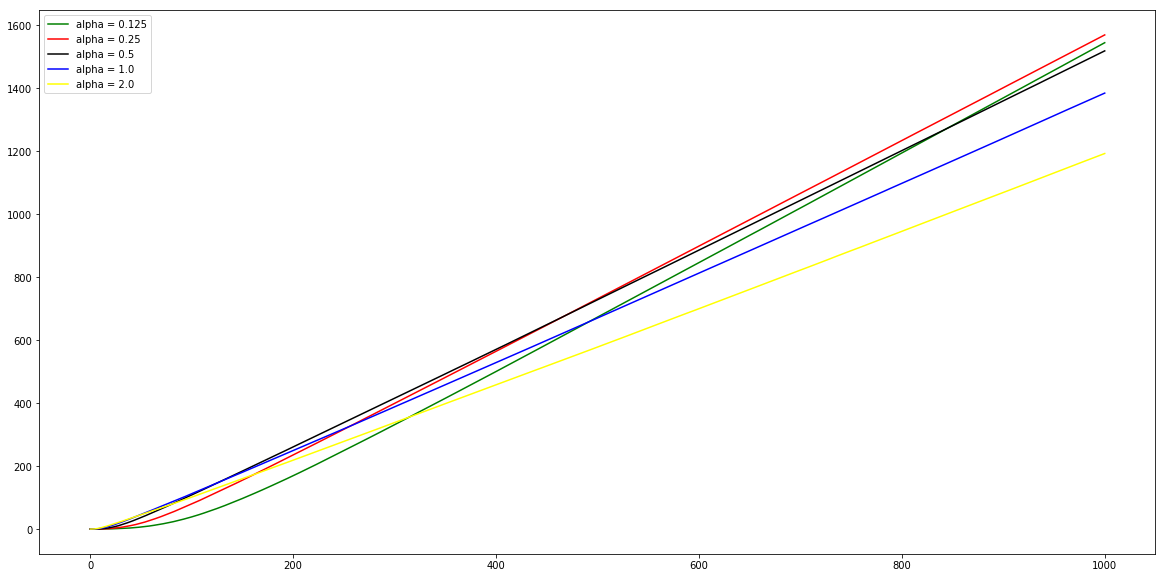

In [14]:
dif_alpha = np.array([0.125, 0.25, 0.5, 1, 2])
history_grad = Try_values(dif_alpha, Play_gradient)
Plot_figure(history_grad, 'alpha', dif_alpha)

В итоге мы видим, что данный метод проигрывает upper confidence bound. Осталось сравнить лучшие результаты описанных методов на графике.

### Comparison

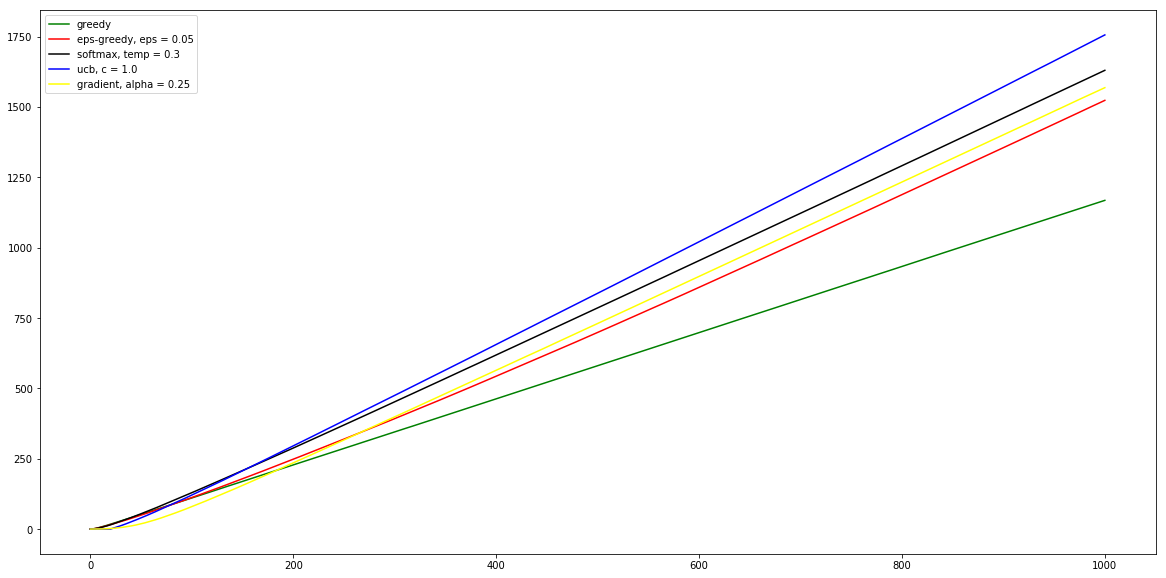

In [15]:
fig = plt.figure(figsize=(20, 10))

plt.plot(range(T + 1), history_eps[0], c=colors[0], label='greedy')
plt.plot(range(T + 1), history_eps[1], c=colors[1], label='eps-greedy, eps = ' + str(dif_eps[1]))
plt.plot(range(T + 1), history_sm[2], c=colors[2], label='softmax, temp = ' + str(dif_temp[2]))
plt.plot(range(T + 1), history_ucb[1], c=colors[3], label='ucb, c = ' + str(dif_c[1]))
plt.plot(range(T + 1), history_grad[1], c=colors[4], label='gradient, alpha = ' + str(dif_alpha[1]))

leg = plt.legend()
plt.show()

Видно, что greedy policy показывает худший результат. При этом с некоторого момента наблюдается стабилизация, т.е. алгоритм начинает эксплуатировать одно и то же действие, из-за чего средний выигрыш перестает расти. У других же стратегий наблюдается постоянный рост на рассматриваемом промежутке.

Использование $\varepsilon$-greedy стратегии значительно увеличивает средний выигрыш, но такой алгоритм все же проигрывает другим стратегиям.

Далее лучшие результаты показывают градиентный метод и жадный алгоритм с исользованием softmax функции.

Однако наилучшим алгоритмом с довольно значительным улучшением качества является метод upper confidence bound.